# Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import os
import pathlib
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical, plot_model, image_dataset_from_directory
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, RandomContrast, RandomRotation, RandomZoom, RandomFlip

# Load the data

In [3]:
data_dir = pathlib.Path("/content/drive/MyDrive/Dataset /archive (2)/dataset")
data = image_dataset_from_directory(data_dir, seed = 123, image_size=(224, 224))
class_names = data.class_names

Found 4227 files belonging to 4 classes.


# Data distribution

<Axes: >

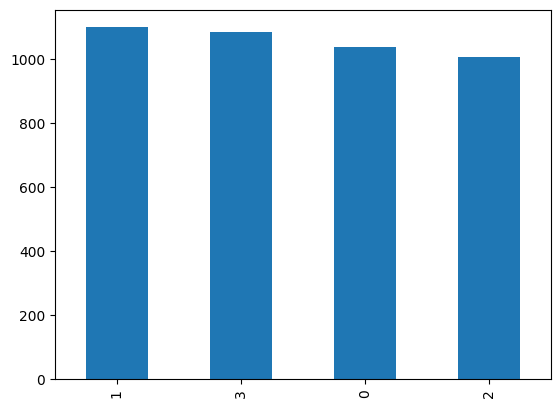

In [4]:
labels = np.concatenate([y for x,y in data], axis=0)
values = pd.value_counts(labels)
values.plot(kind='bar')

# Image samples

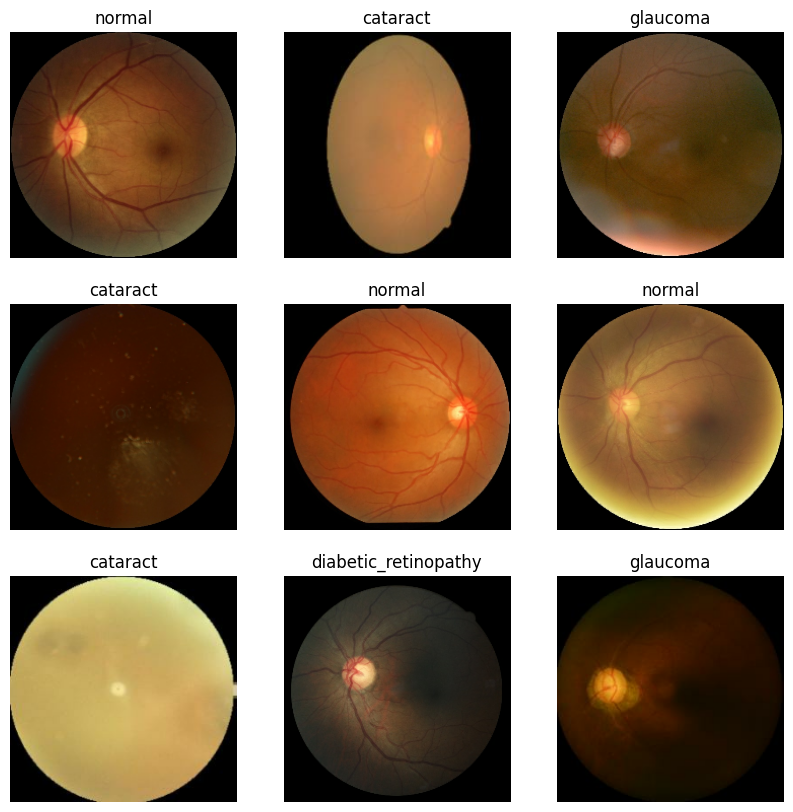

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(data.class_names[labels[i]])
        plt.axis("off")

# Splitting the data

In [6]:
data = data.map(lambda x, y: (x/255, y))
train_size = int(0.7 * len(data)) +1
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))
train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

In [7]:
test_iter = test.as_numpy_iterator()
test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
    try:
        batch = test_iter.next()
        test_set['images'] = np.concatenate((test_set['images'], batch[0]))
        test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
    except:
        break
y_test = test_set['labels']

In [8]:
def evaluate_model(model):
    model.evaluate(test)
    y_pred = np.argmax(model.predict(test_set['images']), 1)
    print(classification_report(y_test, y_pred, target_names = class_names))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sn.heatmap(cm, annot=True)
    plt.xticks(np.arange(4)+.5, class_names, rotation=90)
    plt.yticks(np.arange(4)+.5, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

# Create the CNN model

In [9]:
model = Sequential([
        Conv2D(64, (3,3), activation = 'relu',padding='same', input_shape=(224,224,3)),
        Conv2D(64, (3,3), activation = 'relu',padding='same'),
        Conv2D(64, (3,3), activation = 'relu',padding='same'),
        MaxPool2D(),
        Conv2D(128, (3,3), padding='same', activation = 'relu'),
        Conv2D(128, (3,3),padding='same', activation = 'relu'),
        Conv2D(128, (3,3), activation = 'relu',padding='same'),
        MaxPool2D(),
        Flatten(),
        Dense(256, activation = 'relu'),
        Dense(4, activation='softmax')
    ])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)     147584    
                                                        

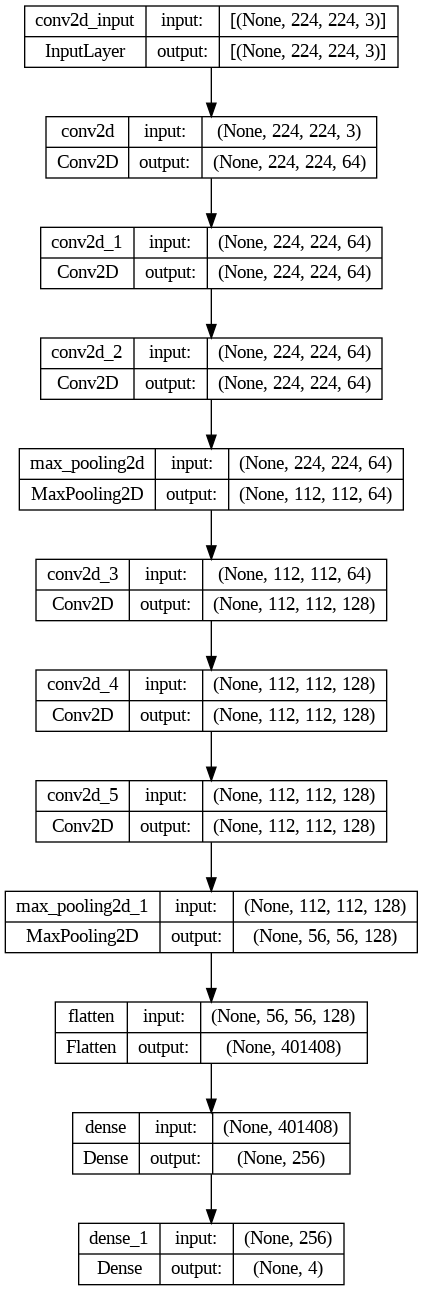

In [ ]:
plot_model(model, to_file='simple-cnn.png', show_shapes=True)

## Train the model

In [11]:
history = model.fit(train, validation_data=val, epochs = 10)

Epoch 1/10
94/94 [==============================] - 92s 803ms/step - loss: 1.1180 - accuracy: 0.5362 - val_loss: 0.7337 - val_accuracy: 0.6683
Epoch 2/10
94/94 [==============================] - 77s 799ms/step - loss: 0.7409 - accuracy: 0.6692 - val_loss: 0.7013 - val_accuracy: 0.6875
Epoch 3/10
94/94 [==============================] - 78s 810ms/step - loss: 0.6451 - accuracy: 0.7211 - val_loss: 0.6252 - val_accuracy: 0.7139
Epoch 4/10
94/94 [==============================] - 77s 798ms/step - loss: 0.5732 - accuracy: 0.7487 - val_loss: 0.6428 - val_accuracy: 0.7248
Epoch 5/10
94/94 [==============================] - 77s 803ms/step - loss: 0.5235 - accuracy: 0.7759 - val_loss: 0.5023 - val_accuracy: 0.8089
Epoch 6/10
94/94 [==============================] - 78s 801ms/step - loss: 0.4868 - accuracy: 0.8115 - val_loss: 0.6141 - val_accuracy: 0.7236
Epoch 7/10
94/94 [==============================] - 77s 798ms/step - loss: 0.4461 - accuracy: 0.8135 - val_loss: 0.5526 - val_accuracy: 0.7945

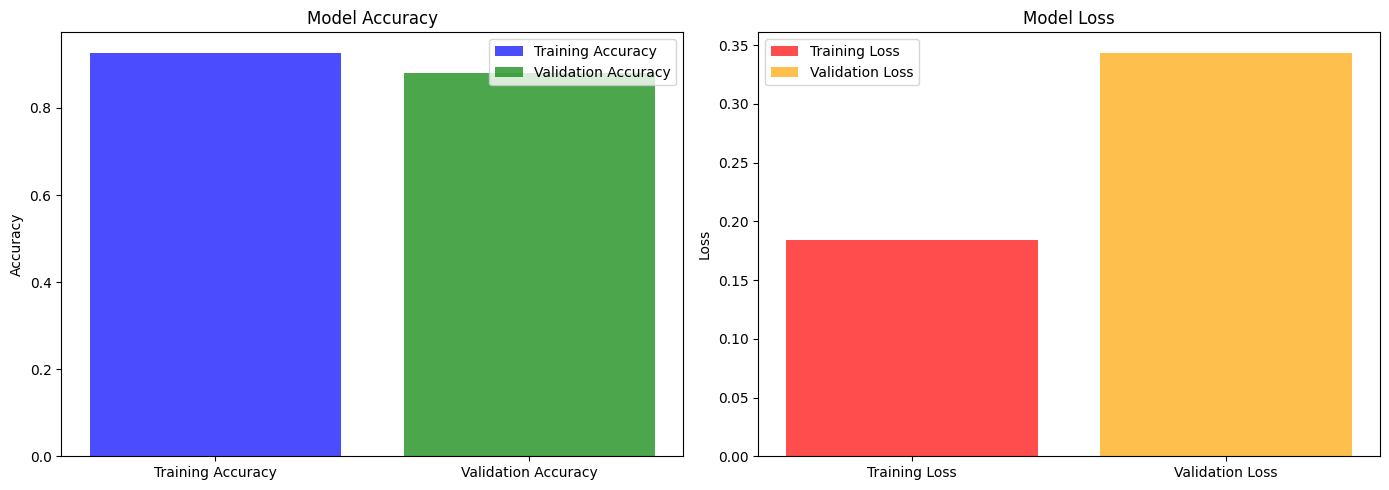

In [12]:
def plot_performance(history):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Create a bar graph for accuracy
    ax1.bar("Training Accuracy", history.history['accuracy'][-1], color='blue', alpha=0.7, label='Training Accuracy')
    ax1.bar("Validation Accuracy", history.history['val_accuracy'][-1], color='green', alpha=0.7, label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Create a bar graph for loss
    ax2.bar("Training Loss", history.history['loss'][-1], color='red', alpha=0.7, label='Training Loss')
    ax2.bar("Validation Loss", history.history['val_loss'][-1], color='orange', alpha=0.7, label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()

# Call the plot_performance function with your training history
plot_performance(history)

## Check the performance of the model

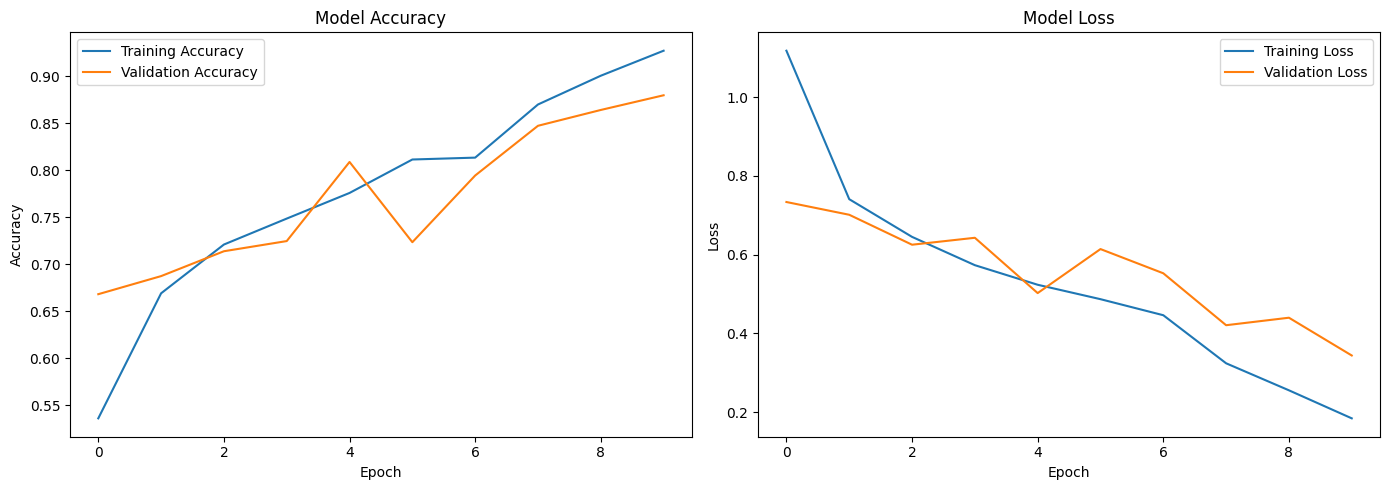

In [13]:
def plot_performance(history):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()

# Call the plot_performance function with your training history
plot_performance(history)




13/13 [==============================] - 1s 96ms/step
                      precision    recall  f1-score   support

            cataract       0.84      0.89      0.86        92
diabetic_retinopathy       1.00      0.99      1.00       101
            glaucoma       0.79      0.72      0.75        96
              normal       0.81      0.85      0.83        98

            accuracy                           0.86       387
           macro avg       0.86      0.86      0.86       387
        weighted avg       0.86      0.86      0.86       387



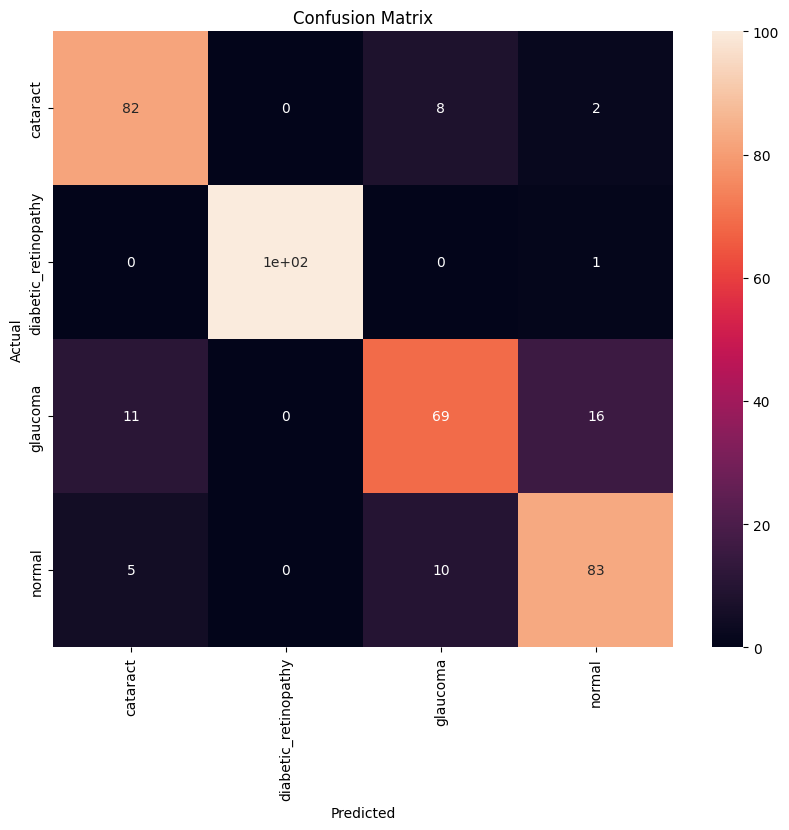

In [14]:
evaluate_model(model)

# Explaining predictions with LIME

In [15]:
!pip install lime

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=e1d5fd393bad031656ea7f3a1d7ee36a94d69d50838b97c395e6d48db5eb9cc2
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [16]:
from tensorflow.keras.preprocessing import image
from skimage.io import imread
from skimage.transform import resize

def predict_image(image_path):
    img = imread(image_path)
    img = resize(img, (224,224))

    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)
    prediction = np.argmax(preds)
    pct = np.max(preds)
    if prediction == 0:
        print('Cataract')
    elif prediction == 1:
        print('Diabetic retinopathy')
    elif prediction == 2:
        print('Glaucoma')
    else:
        print('Normal')
    print(pct)
    return img

In [17]:
def explain_prediction(image_path):
    img = predict_image(image_path)
    explainer = lime_image.LimeImageExplainer(random_state=12)
    explanation = explainer.explain_instance(
             img[0].astype('double'),
             model.predict
    )
    from skimage.segmentation import mark_boundaries

    temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    ax1.imshow(mark_boundaries(temp_1, mask_1))
    ax2.imshow(mark_boundaries(temp_2, mask_2))
    ax1.axis('off')
    ax2.axis('off')

1/1 [==============================] - 1s 1s/step
Glaucoma
0.99996424


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


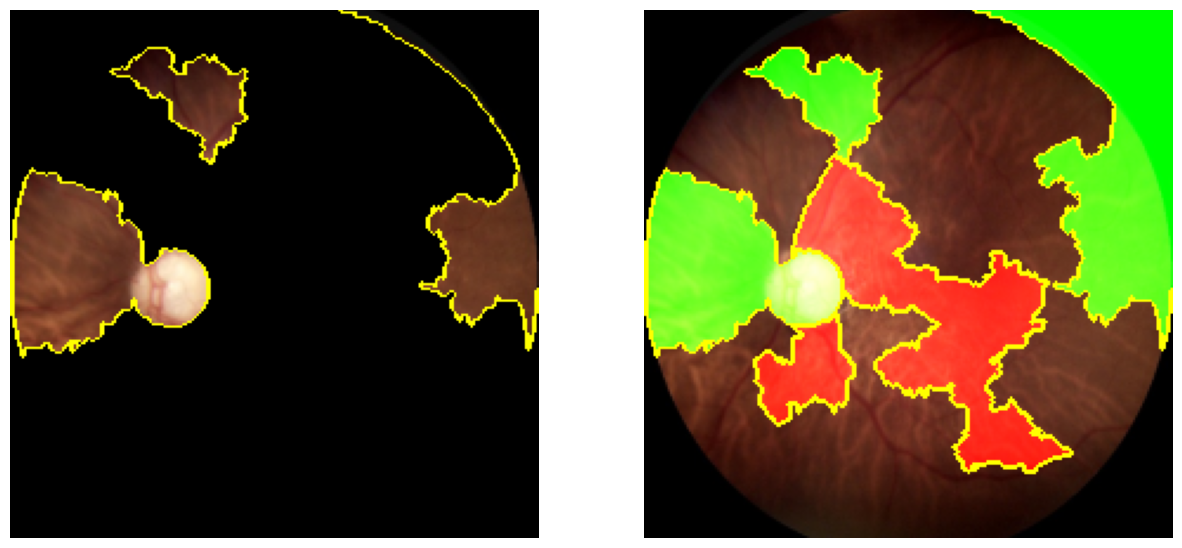

In [18]:
explain_prediction("/content/drive/MyDrive/Dataset /archive (2)/dataset/glaucoma/1212_left.jpg")

1/1 [==============================] - 0s 17ms/step
Glaucoma
0.99708647


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


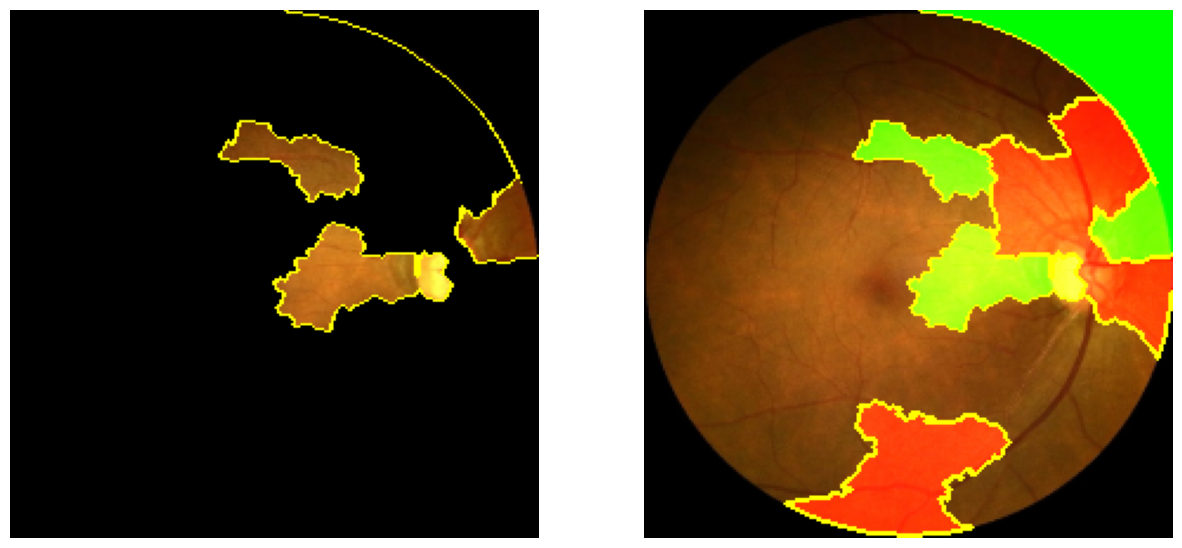

In [19]:
explain_prediction("/content/drive/MyDrive/Dataset /archive (2)/dataset/glaucoma/1389_right.jpg")

1/1 [==============================] - 0s 27ms/step
Glaucoma
0.99937624


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


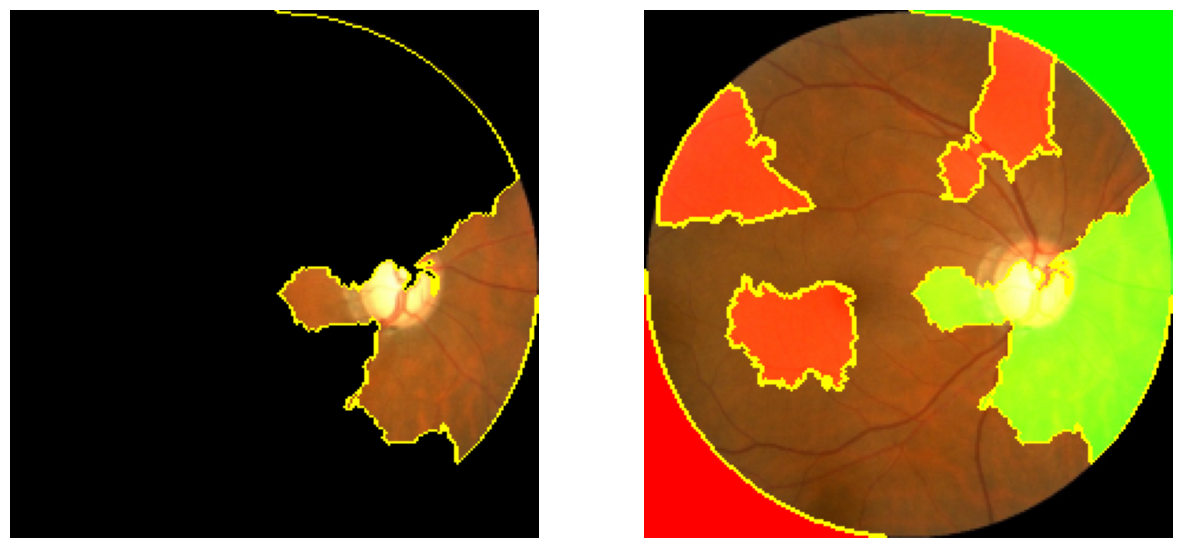

In [20]:
explain_prediction("/content/drive/MyDrive/Dataset /archive (2)/dataset/glaucoma/1220_right.jpg")

# Add data augmentation

In [21]:
data_augmentation = Sequential([
    RandomContrast(0.4),
    RandomZoom(0.2, fill_mode="constant")
])

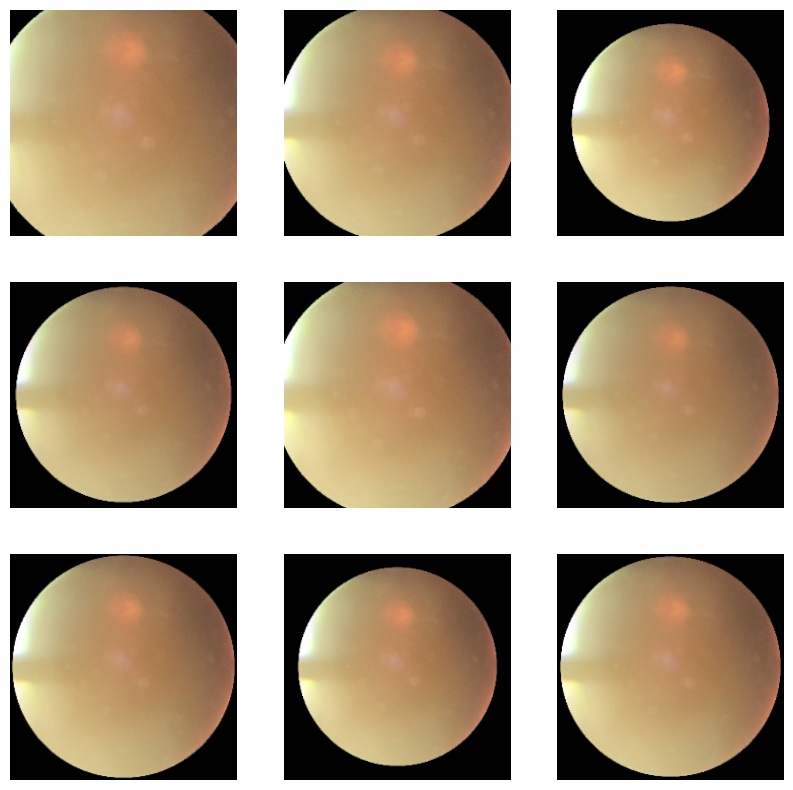

In [22]:
i = 0
for images, labels in train.take(1):
    image = tf.cast(tf.expand_dims(images[i].numpy(), 0), tf.float32)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        augmented_image = data_augmentation(image)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0])
        plt.axis("off")
    break

## Data augmentation

In [23]:
model = Sequential([
        data_augmentation,
        Conv2D(64, (3,3), activation = 'relu',padding='same', input_shape=(224,224,3)),
        Conv2D(64, (3,3), activation = 'relu',padding='same'),
        Conv2D(64, (3,3), activation = 'relu',padding='same'),
        MaxPool2D(),
        Conv2D(128, (3,3), padding='same', activation = 'relu'),
        Conv2D(128, (3,3),padding='same', activation = 'relu'),
        Conv2D(128, (3,3), activation = 'relu',padding='same'),
        MaxPool2D(),
        Flatten(),
        Dense(256, activation = 'relu'),
        Dense(4, activation='softmax')
    ])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
history = model.fit(train, validation_data=val, epochs = 10)

Epoch 1/10
94/94 [==============================] - 81s 804ms/step - loss: 1.4105 - accuracy: 0.3391 - val_loss: 1.3129 - val_accuracy: 0.4651
Epoch 2/10
94/94 [==============================] - 77s 798ms/step - loss: 1.1692 - accuracy: 0.4601 - val_loss: 1.0464 - val_accuracy: 0.5373
Epoch 3/10
94/94 [==============================] - 77s 797ms/step - loss: 1.0896 - accuracy: 0.5076 - val_loss: 1.1616 - val_accuracy: 0.4483
Epoch 4/10
94/94 [==============================] - 78s 814ms/step - loss: 1.0551 - accuracy: 0.5336 - val_loss: 1.0246 - val_accuracy: 0.5361
Epoch 5/10
94/94 [==============================] - 76s 797ms/step - loss: 0.9782 - accuracy: 0.5735 - val_loss: 1.0532 - val_accuracy: 0.5409
Epoch 6/10
94/94 [==============================] - 76s 797ms/step - loss: 0.9205 - accuracy: 0.5991 - val_loss: 0.9137 - val_accuracy: 0.5889
Epoch 7/10
94/94 [==============================] - 77s 798ms/step - loss: 0.8344 - accuracy: 0.6257 - val_loss: 0.8551 - val_accuracy: 0.6346

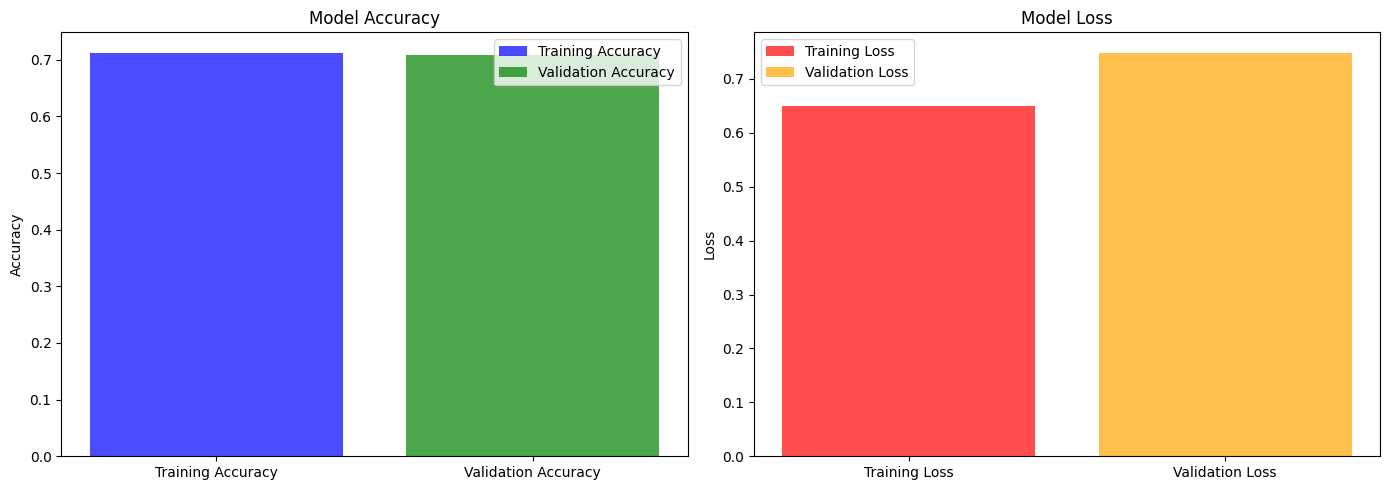

In [25]:
def plot_performance(history):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Create a bar graph for accuracy
    ax1.bar("Training Accuracy", history.history['accuracy'][-1], color='blue', alpha=0.7, label='Training Accuracy')
    ax1.bar("Validation Accuracy", history.history['val_accuracy'][-1], color='green', alpha=0.7, label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Create a bar graph for loss
    ax2.bar("Training Loss", history.history['loss'][-1], color='red', alpha=0.7, label='Training Loss')
    ax2.bar("Validation Loss", history.history['val_loss'][-1], color='orange', alpha=0.7, label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()

# Call the plot_performance function with your training history
plot_performance(history)

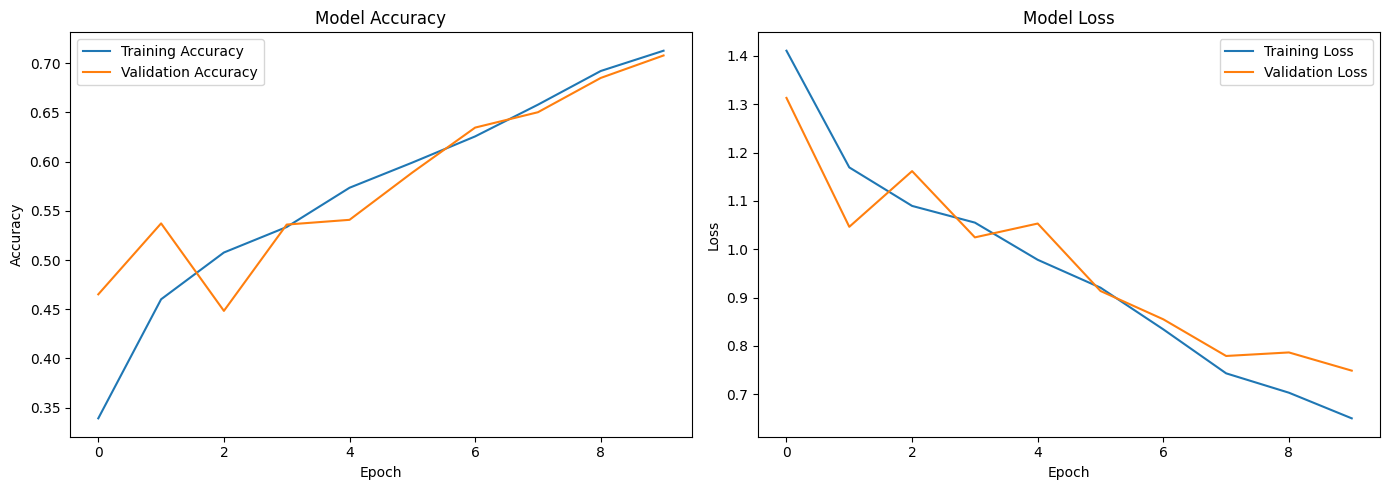

In [26]:
def plot_performance(history):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()

# Call the plot_performance function with your training history
plot_performance(history)

13/13 [==============================] - 1s 95ms/step
                      precision    recall  f1-score   support

            cataract       0.58      0.88      0.70        92
diabetic_retinopathy       0.98      0.92      0.95       101
            glaucoma       0.74      0.24      0.36        96
              normal       0.62      0.78      0.69        98

            accuracy                           0.71       387
           macro avg       0.73      0.70      0.68       387
        weighted avg       0.74      0.71      0.68       387



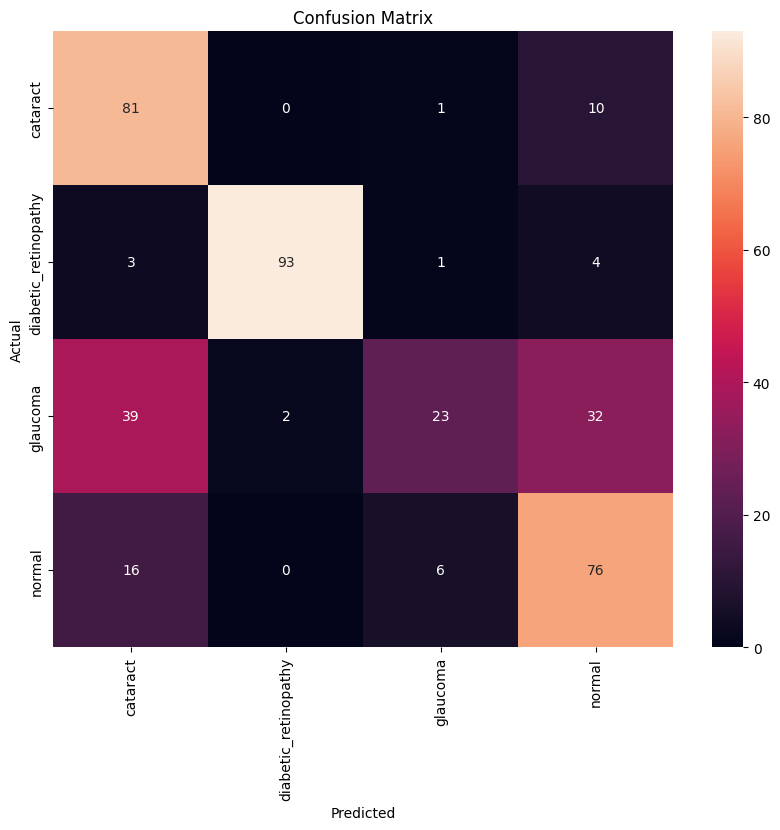

In [27]:
evaluate_model(model)

# Transfer learning

## DensetNet121

In [28]:
from tensorflow.keras.applications import DenseNet121
dense = DenseNet121(weights = "imagenet", include_top = False, input_shape=(224,224,3))
for layer in dense.layers[:121]:
    layer.trainable = False

29084464/29084464 [==============================] - 0s 0us/step


In [29]:
model = Sequential([
    dense,
    MaxPool2D(2),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(4, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 3, 3, 1024)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 3, 3, 1024)        0         
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               1179776   
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                      

In [30]:
history = model.fit(train,validation_data=val,epochs = 10)

Epoch 1/10
94/94 [==============================] - 118s 758ms/step - loss: 1.0187 - accuracy: 0.7723 - val_loss: 0.5724 - val_accuracy: 0.7993
Epoch 2/10
94/94 [==============================] - 72s 747ms/step - loss: 0.2994 - accuracy: 0.8890 - val_loss: 0.4682 - val_accuracy: 0.8870
Epoch 3/10
94/94 [==============================] - 72s 753ms/step - loss: 0.2249 - accuracy: 0.9176 - val_loss: 0.4655 - val_accuracy: 0.8486
Epoch 4/10
94/94 [==============================] - 72s 751ms/step - loss: 0.2773 - accuracy: 0.9126 - val_loss: 37.8768 - val_accuracy: 0.2752
Epoch 5/10
94/94 [==============================] - 73s 758ms/step - loss: 0.1697 - accuracy: 0.9375 - val_loss: 0.3803 - val_accuracy: 0.8918
Epoch 6/10
94/94 [==============================] - 72s 751ms/step - loss: 0.1157 - accuracy: 0.9571 - val_loss: 0.2954 - val_accuracy: 0.9183
Epoch 7/10
94/94 [==============================] - 72s 754ms/step - loss: 0.1055 - accuracy: 0.9624 - val_loss: 0.3691 - val_accuracy: 0.88

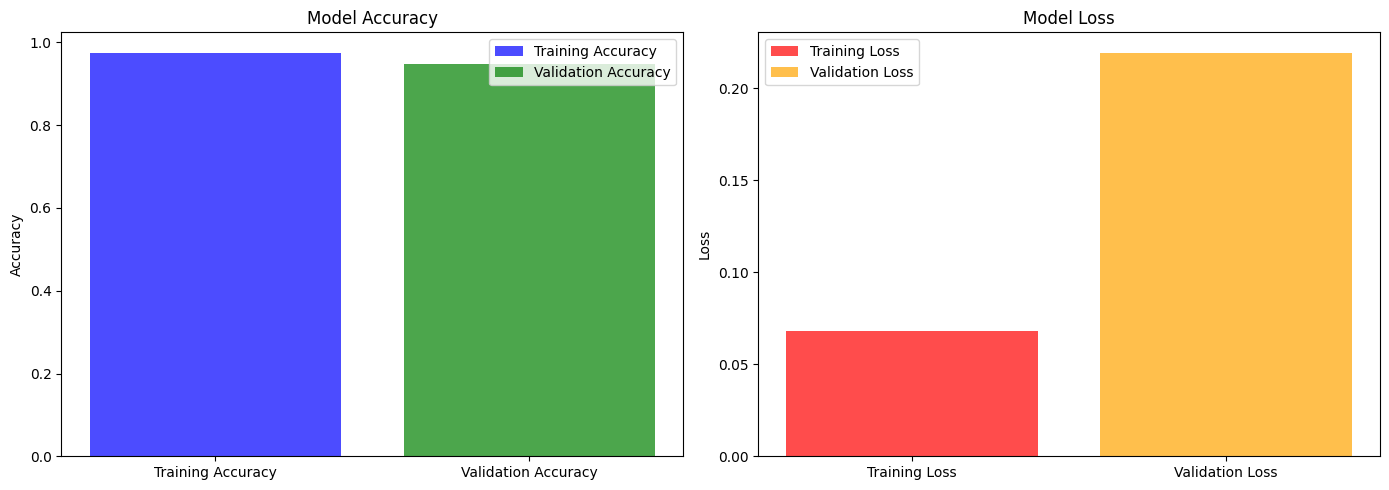

In [31]:
def plot_performance(history):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Create a bar graph for accuracy
    ax1.bar("Training Accuracy", history.history['accuracy'][-1], color='blue', alpha=0.7, label='Training Accuracy')
    ax1.bar("Validation Accuracy", history.history['val_accuracy'][-1], color='green', alpha=0.7, label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Create a bar graph for loss
    ax2.bar("Training Loss", history.history['loss'][-1], color='red', alpha=0.7, label='Training Loss')
    ax2.bar("Validation Loss", history.history['val_loss'][-1], color='orange', alpha=0.7, label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()

# Call the plot_performance function with your training history
plot_performance(history)

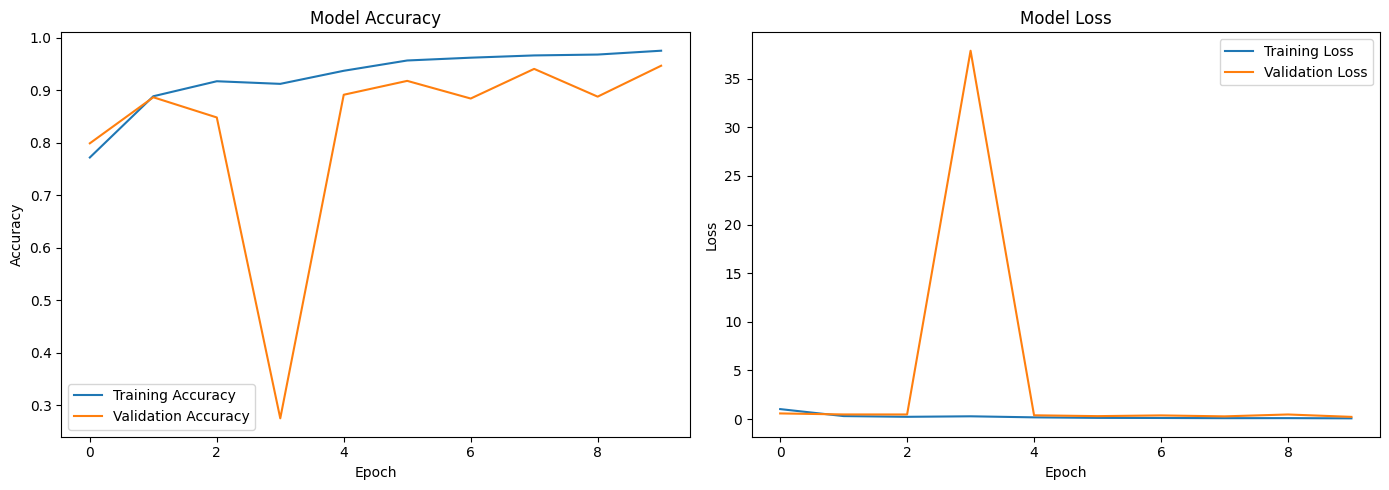

In [32]:
def plot_performance(history):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()

# Call the plot_performance function with your training history
plot_performance(history)

13/13 [==============================] - 3s 92ms/step
                      precision    recall  f1-score   support

            cataract       0.93      0.96      0.94        92
diabetic_retinopathy       1.00      0.98      0.99       101
            glaucoma       0.90      0.88      0.89        96
              normal       0.91      0.93      0.92        98

            accuracy                           0.94       387
           macro avg       0.93      0.94      0.93       387
        weighted avg       0.94      0.94      0.94       387



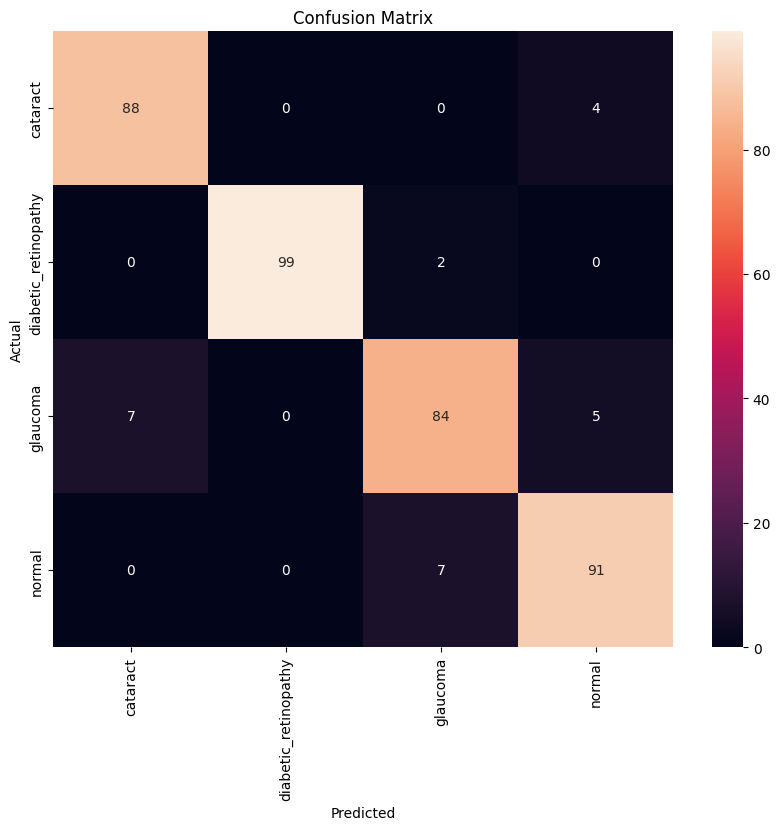

In [33]:
evaluate_model(model)

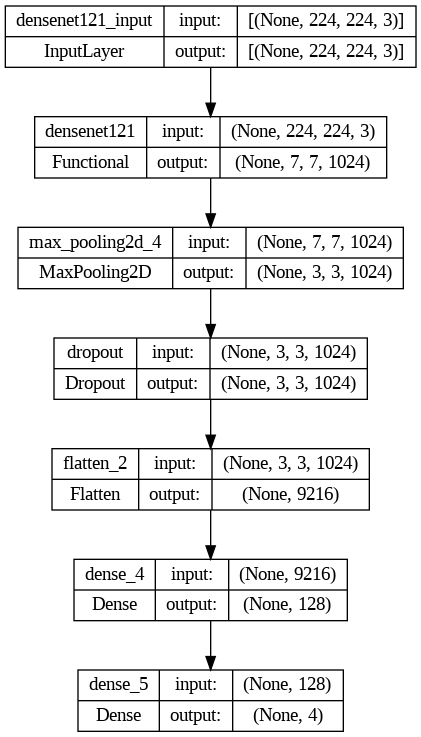

In [34]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='densenet.png', show_shapes=True)

## EfficientNet

In [35]:
from keras.applications.efficientnet import EfficientNetB0
effnet = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3), pooling='max')
effnet.trainable = False
for layer in effnet.layers[83:]:
    layer.trainable = True

16705208/16705208 [==============================] - 0s 0us/step


In [36]:
model = Sequential([
    effnet,
    BatchNormalization(),
    Dense(512, activation = 'relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 4712615 (17.98 MB)
Trainable params: 660

In [38]:
history = model.fit(train,validation_data=val,epochs = 10)

Epoch 1/10
94/94 [==============================] - 77s 689ms/step - loss: 2.0735 - accuracy: 0.4089 - val_loss: 3.6241 - val_accuracy: 0.2212
Epoch 2/10
94/94 [==============================] - 67s 703ms/step - loss: 1.6564 - accuracy: 0.4731 - val_loss: 6.7508 - val_accuracy: 0.2284
Epoch 3/10
94/94 [==============================] - 67s 703ms/step - loss: 1.3668 - accuracy: 0.5150 - val_loss: 2.5928 - val_accuracy: 0.2704
Epoch 4/10
94/94 [==============================] - 66s 683ms/step - loss: 1.2000 - accuracy: 0.5306 - val_loss: 1.4596 - val_accuracy: 0.3281
Epoch 5/10
94/94 [==============================] - 67s 703ms/step - loss: 1.1204 - accuracy: 0.5459 - val_loss: 1.8403 - val_accuracy: 0.3041
Epoch 6/10
94/94 [==============================] - 68s 707ms/step - loss: 1.0637 - accuracy: 0.5293 - val_loss: 1.6274 - val_accuracy: 0.4255
Epoch 7/10
94/94 [==============================] - 68s 700ms/step - loss: 1.0311 - accuracy: 0.5436 - val_loss: 2.1307 - val_accuracy: 0.3582

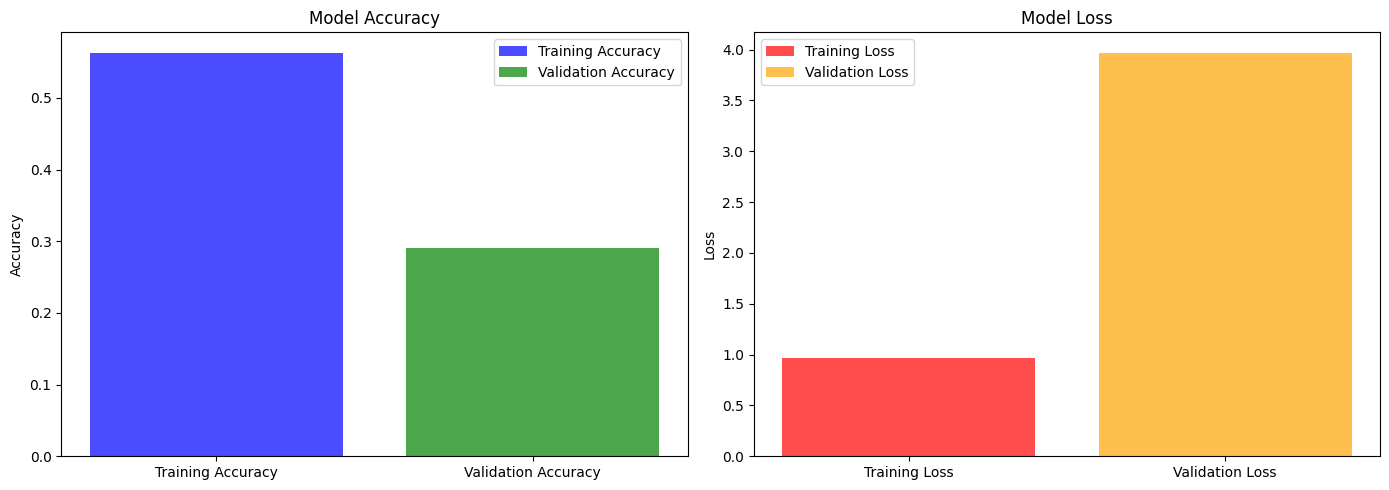

In [39]:
def plot_performance(history):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Create a bar graph for accuracy
    ax1.bar("Training Accuracy", history.history['accuracy'][-1], color='blue', alpha=0.7, label='Training Accuracy')
    ax1.bar("Validation Accuracy", history.history['val_accuracy'][-1], color='green', alpha=0.7, label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Create a bar graph for loss
    ax2.bar("Training Loss", history.history['loss'][-1], color='red', alpha=0.7, label='Training Loss')
    ax2.bar("Validation Loss", history.history['val_loss'][-1], color='orange', alpha=0.7, label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()

# Call the plot_performance function with your training history
plot_performance(history)

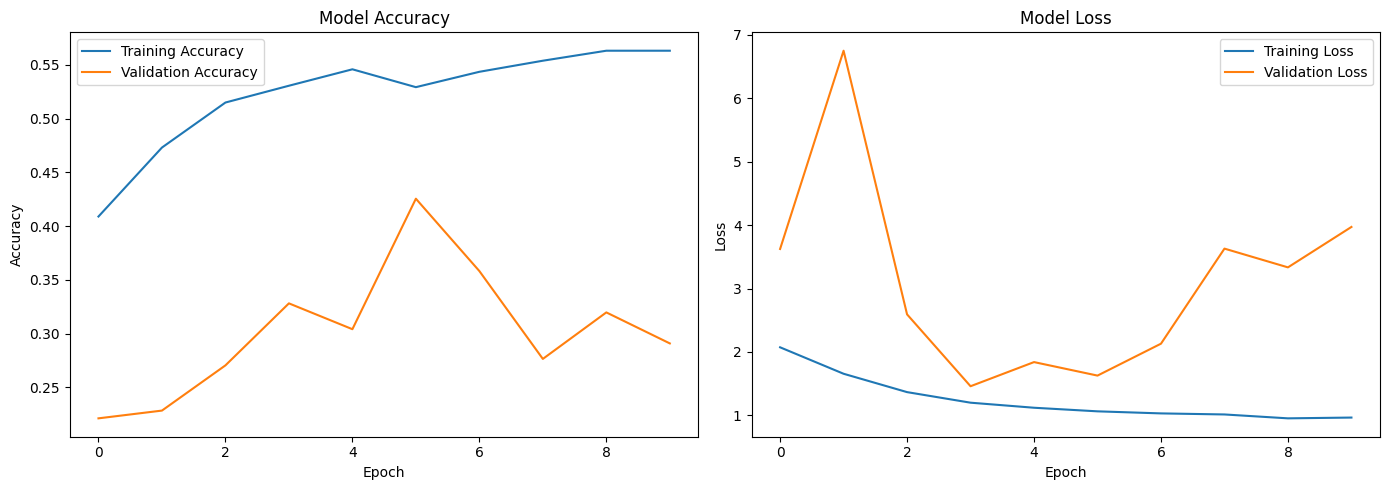

In [40]:
def plot_performance(history):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()

# Call the plot_performance function with your training history
plot_performance(history)

13/13 [==============================] - 2s 62ms/step
                      precision    recall  f1-score   support

            cataract       1.00      0.02      0.04        92
diabetic_retinopathy       0.28      1.00      0.43       101
            glaucoma       0.25      0.01      0.02        96
              normal       0.47      0.08      0.14        98

            accuracy                           0.29       387
           macro avg       0.50      0.28      0.16       387
        weighted avg       0.49      0.29      0.16       387



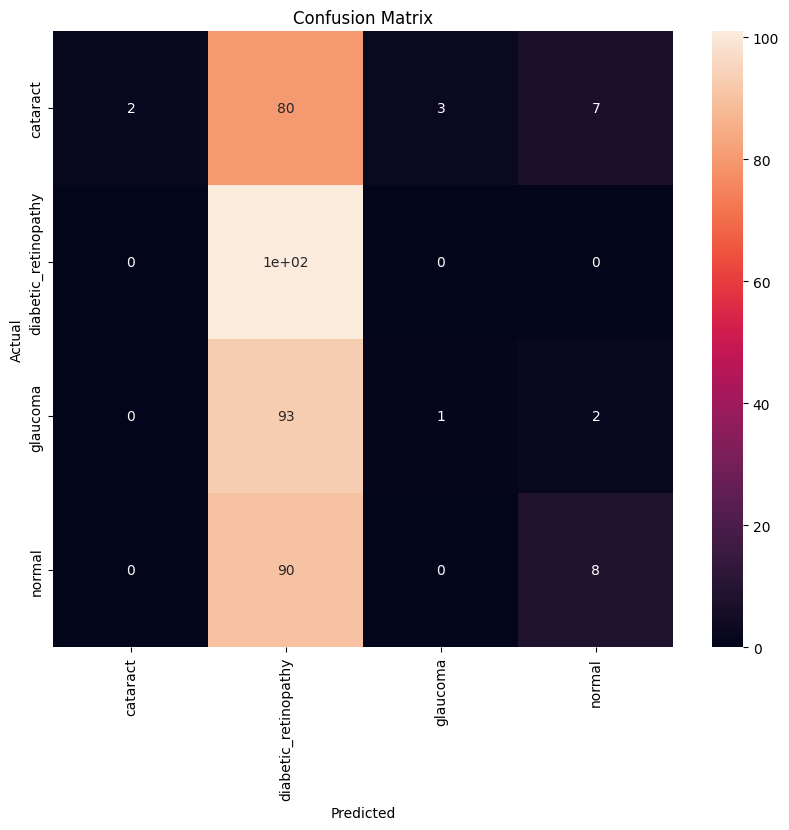

In [41]:
evaluate_model(model)

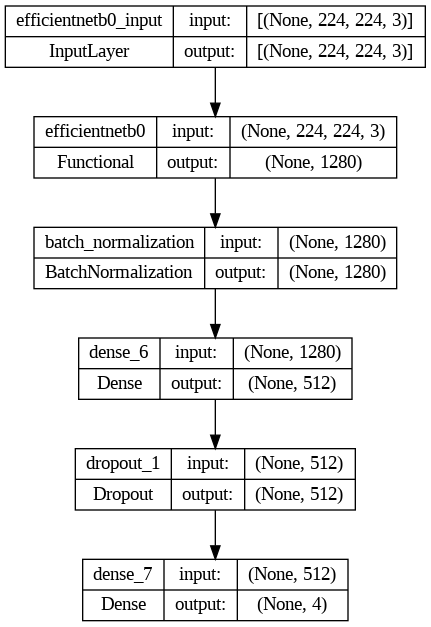

In [ ]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='efficientnet.png', show_shapes=True)

## VGG16

In [42]:
from keras.applications.vgg16 import VGG16
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
for layer in vgg16.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [43]:
model = Sequential([
    vgg16,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation = 'relu'),
    Dense(4, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_2 (Dropout)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               3211392   
                                                                 
 dense_9 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17926596 (68.38 MB)
Trainable params: 3211908 (12.25 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [45]:
history = model.fit(train,validation_data=val,epochs = 10)

Epoch 1/10
94/94 [==============================] - 60s 557ms/step - loss: 1.0367 - accuracy: 0.6499 - val_loss: 0.4507 - val_accuracy: 0.8257
Epoch 2/10
94/94 [==============================] - 68s 704ms/step - loss: 0.4334 - accuracy: 0.8285 - val_loss: 0.3861 - val_accuracy: 0.8425
Epoch 3/10
94/94 [==============================] - 57s 586ms/step - loss: 0.3844 - accuracy: 0.8501 - val_loss: 0.3426 - val_accuracy: 0.8642
Epoch 4/10
94/94 [==============================] - 67s 692ms/step - loss: 0.3516 - accuracy: 0.8600 - val_loss: 0.3613 - val_accuracy: 0.8510
Epoch 5/10
94/94 [==============================] - 68s 700ms/step - loss: 0.3203 - accuracy: 0.8720 - val_loss: 0.3041 - val_accuracy: 0.8798
Epoch 6/10
94/94 [==============================] - 68s 704ms/step - loss: 0.3125 - accuracy: 0.8777 - val_loss: 0.3151 - val_accuracy: 0.8810
Epoch 7/10
94/94 [==============================] - 66s 687ms/step - loss: 0.2975 - accuracy: 0.8866 - val_loss: 0.3028 - val_accuracy: 0.8810

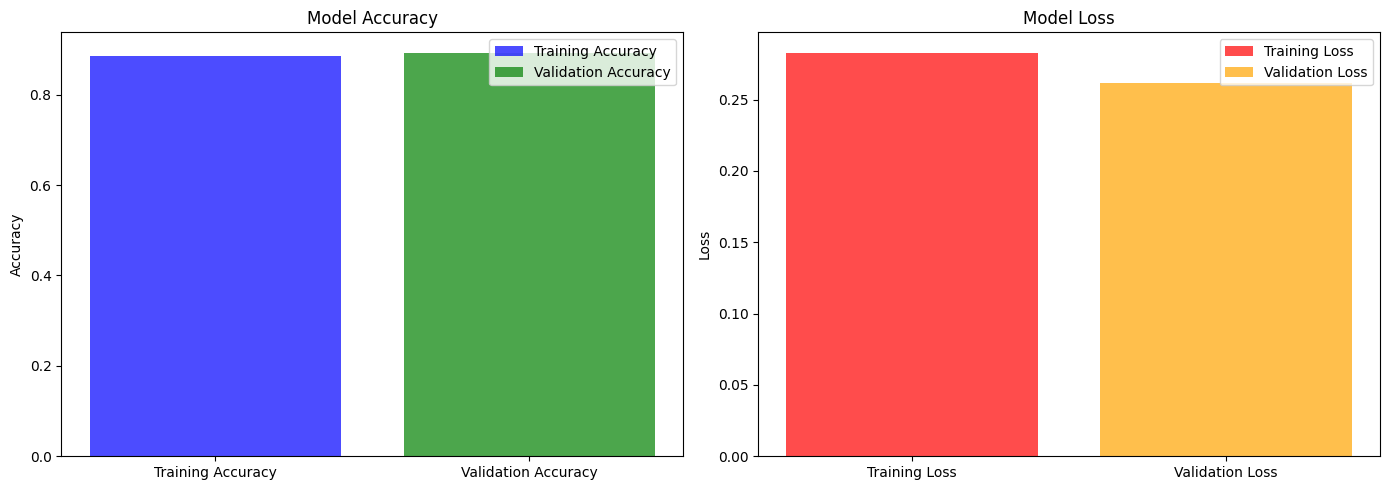

In [46]:
def plot_performance(history):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Create a bar graph for accuracy
    ax1.bar("Training Accuracy", history.history['accuracy'][-1], color='blue', alpha=0.7, label='Training Accuracy')
    ax1.bar("Validation Accuracy", history.history['val_accuracy'][-1], color='green', alpha=0.7, label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Create a bar graph for loss
    ax2.bar("Training Loss", history.history['loss'][-1], color='red', alpha=0.7, label='Training Loss')
    ax2.bar("Validation Loss", history.history['val_loss'][-1], color='orange', alpha=0.7, label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()

# Call the plot_performance function with your training history
plot_performance(history)

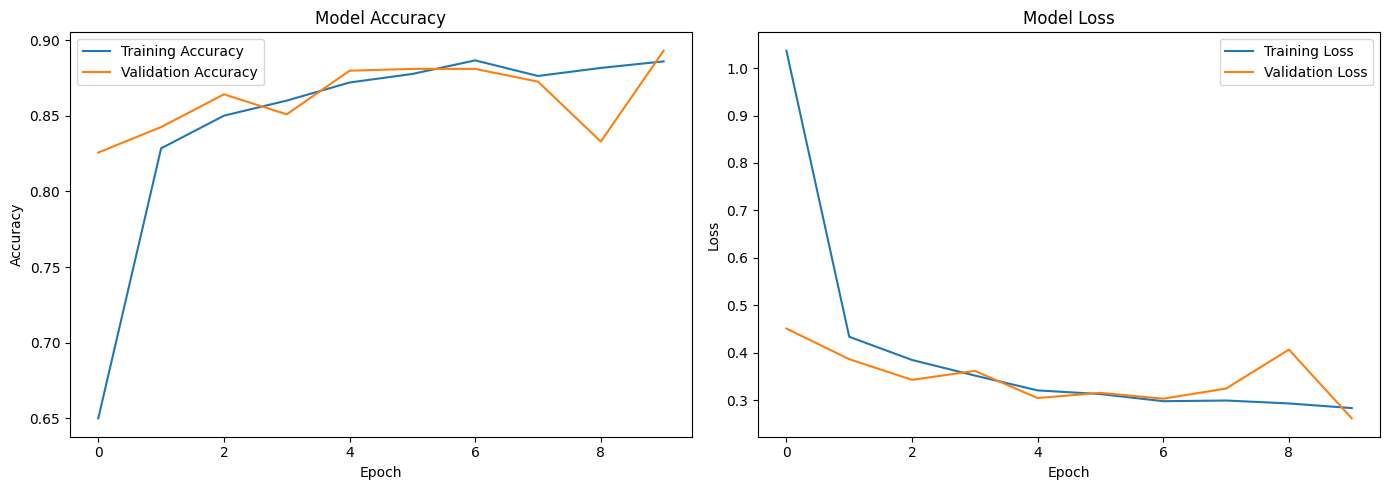

In [47]:
def plot_performance(history):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot training & validation loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()

# Call the plot_performance function with your training history
plot_performance(history)

13/13 [==============================] - 2s 138ms/step
                      precision    recall  f1-score   support

            cataract       0.89      0.86      0.87        92
diabetic_retinopathy       0.98      1.00      0.99       101
            glaucoma       0.85      0.75      0.80        96
              normal       0.83      0.93      0.87        98

            accuracy                           0.89       387
           macro avg       0.89      0.88      0.88       387
        weighted avg       0.89      0.89      0.88       387



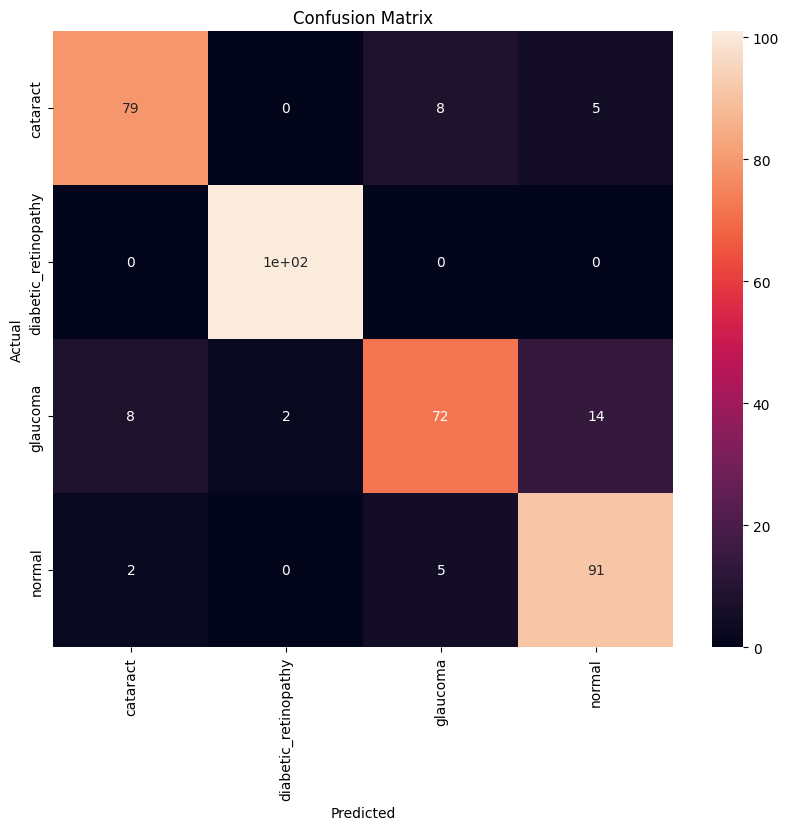

In [48]:
evaluate_model(model)

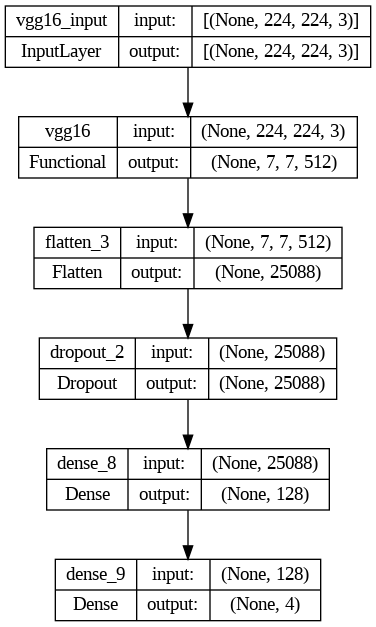

In [ ]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='vgg16.png', show_shapes=True)

In [58]:
from sklearn.model_selection import GridSearchCV

# Assuming y_test is a pandas Series
# Get correct labels from the validation dataset
target_labels = np.concatenate([y for x, y in val], axis=0)

# Step 1: Obtain Predictions from Deep Learning Models
predictions_densenet = model.predict(val)  # Use your DenseNet121-based model
predictions_effnet = model.predict(val)      # Use your EfficientNetB0-based model
predictions_vgg16 = model.predict(val)        # Use your VGG16-based model

# Step 2: Prepare Data for XGBoost
xgboost_data = np.concatenate([predictions_densenet, predictions_effnet, predictions_vgg16], axis=1)

# Ensure both xgboost_data and target_labels have the same length
assert xgboost_data.shape[0] == len(target_labels), "Inconsistent number of samples"

# Step 3: Train XGBoost Model with GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

xgb_classifier = xgb.XGBClassifier()
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=3, scoring='accuracy')
grid_search.fit(xgboost_data, target_labels)

# Print the best parameters found by the grid search
print("Best Parameters:", grid_search.best_params_)

# Make predictions on the test set
y_pred_xgb = grid_search.predict(X_test)

# Evaluate XGBoost model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)


26/26 [==============================] - 31s 237ms/step
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
XGBoost Accuracy: 0.23952095808383234


In [61]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

# Assuming y_test is a pandas Series
# Get correct labels from the validation dataset
target_labels = np.concatenate([y for x, y in val], axis=0)

# Step 1: Obtain Predictions from Deep Learning Models
predictions_densenet = model.predict(val)  # Use your DenseNet121-based model
predictions_effnet = model.predict(val)      # Use your EfficientNetB0-based model
predictions_vgg16 = model.predict(val)        # Use your VGG16-based model

# Step 2: Prepare Data for LightGBM
lightgbm_data = np.concatenate([predictions_densenet, predictions_effnet, predictions_vgg16], axis=1)

# Ensure both lightgbm_data and target_labels have the same length
assert lightgbm_data.shape[0] == len(target_labels), "Inconsistent number of samples"

# Step 3: Train LightGBM Model with GridSearchCV
param_grid = {
    'num_leaves': [31, 63, 127],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

# Extract the best value for num_leaves from the grid search results
best_num_leaves = grid_search.best_params_['num_leaves']

lgb_classifier = lgb.LGBMClassifier(num_leaves=best_num_leaves)
grid_search = GridSearchCV(lgb_classifier, param_grid, cv=3, scoring='accuracy')
grid_search.fit(lightgbm_data, target_labels)

# Print the best parameters found by the grid search
print("Best Parameters:", grid_search.best_params_)

# Make predictions on the test set
y_pred_lgb = grid_search.predict(X_test)

# Evaluate LightGBM model
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print("LightGBM Accuracy:", accuracy_lgb)



Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit